# NHL Draft data from NHL Records API

Dataset generated from a JSON received from the NHL Records API, contains response to the request for all draft records.

For details, see notebook `notebooks/feature_extraction/nhl_api.ipynb`.

# Data cleanup and feature extraction
Only basic cleanup was performed via this notebook, more detailed cleanup was done using Tableau Prep.
## Cleanup plan
1. Fix inconsistent capitalizations
2. Remove records with missing place of birth and date of birth
3. Extract country of birth from birth place
4. Fix erratic height and weight values
5. Remove redundant positions
    * all players capable of playing the center are assumed to be centers (C)
    * LW/RW are assumed to be right wings (RW)
    * mixed D positions are assumed to be defencemen (D)
5. Produce new variables:
    * `1st_round`: boolean, whether the prospect was selected in the $1^{st}$ round
        * one-hot encoding for $1^{st}$ round picks
        * True if `round` == 1, False otherwise
6. Filter and rename columns
7. Save results to a new .csv file

In [1]:
import numpy as np
import pandas as pd
from time import time
import os

In [2]:
os.chdir('Documents/repos/nhl_draft/')
os.listdir()

['.git',
 '.gitattributes',
 '.gitignore',
 '.idea',
 'auxil',
 'data',
 'Datasources',
 'Flows',
 'img',
 'Logs',
 'machineId.txt',
 'main.py',
 'methodology',
 'models',
 'notebooks',
 'out',
 'README.md',
 'references',
 'reports',
 'requirements.txt',
 'src']

In [3]:
draft_api_data_path = 'data/nhl_api/nhl_draft_all.csv'
t = time()
df = pd.read_csv(draft_api_data_path,
                 parse_dates=['birthDate',
                              'draftYear'])
df['csPlayerId'] = df['csPlayerId'].astype('int')
# df = df.rename(columns={'Unnamed: 0': 'id'})
elapsed = time() - t
print("----- DataFrame with NHL Draft Data loaded"
      "\nin {0:.2f} seconds".format(elapsed) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- DataFrame with NHL Draft Data loaded
in 0.24 seconds
with 11,587 rows
and 25 columns
-- Column names:
 Index(['amateurClubName', 'amateurLeague', 'birthDate', 'birthPlace',
       'countryCode', 'csPlayerId', 'draftYear', 'draftedByTeamId',
       'firstName', 'height', 'id', 'lastName', 'overallPickNumber',
       'pickInRound', 'playerId', 'playerName', 'position', 'removedOutright',
       'removedOutrightWhy', 'roundNumber', 'shootsCatches',
       'supplementalDraft', 'teamPickHistory', 'triCode', 'weight'],
      dtype='object')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11587 entries, 0 to 11586
Data columns (total 25 columns):
amateurClubName       11492 non-null object
amateurLeague         11471 non-null object
birthDate             11526 non-null datetime64[ns]
birthPlace            11530 non-null object
countryCode           11580 non-null object
csPlayerId            4854 non-null float64
draftYear             11587 non-null datetime64[ns]
draftedByTeamId       11587 non-null int64
firstName             11580 non-null object
height                11502 non-null float64
id                    11587 non-null int64
lastName              11580 non-null object
overallPickNumber     11587 non-null int64
pickInRound           11587 non-null int64
playerId              10800 non-null float64
playerName            11580 non-null object
position              11580 non-null object
removedOutright       11587 non-null object
removedOutrightWhy    88 non-null object
roundNumber           11587 non-null int64
s

## Fix inconsistent capitalizations

In [5]:
cols = ['amateurClubName', 'birthPlace', 'playerName', 'lastName']
for col in cols:
    df[col] = df[col].str.title()
print("Capitalizations fixed!")

Capitalizations fixed!


## Remove records with missing place of birth and date of birth
There is a low number of records with missing place of birth and country of birth, since these records do not appear to be very important, they are removed from the dataset.
### Missing place of birth

In [6]:
col = 'birthPlace'
mask1 = df[col].isnull()
mask2 = df['overallPickNumber'] < 60
s = df[mask1]
print("From the total {0:,} records in the dataset,\n{1:,}, or {2:.2f}% "
      "of all drafted players, have missing {3}.".format(len(df),
                                                  len(df[mask1]),
                                                  len(s) / len(df) * 100,
                                                  col),
      "\nFrom these records, {0:,} ({1:.2f}% of all drafted players) "
      "\nhave been picking in either the first of the second "
      "round of draft.".format(len(s[mask2]),
                               len(s[mask2]) / len(df) * 100))

From the total 11,587 records in the dataset,
57, or 0.49% of all drafted players, have missing birthPlace. 
From these records, 6 (0.05% of all drafted players) 
have been picking in either the first of the second round of draft.


C:\Anaconda3\envs\nhl_draft\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Anaconda3\envs\nhl_draft\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


### Missing date of birth

In [7]:
col = 'birthDate'
mask1 = df[col].isnull()
mask2 = df['overallPickNumber'] < 60
s = df[mask1]
print("From the total {0:,} records in the dataset,\n{1:,}, or {2:.2f}% "
      "of all drafted players, have missing {3}.".format(len(df),
                                                  len(df[mask1]),
                                                  len(s) / len(df) * 100,
                                                  col),
      "\nFrom these records, {0:,} ({1:.2f}% of all drafted players) "
      "\nhave been picking in either the first of the second "
      "round of draft.".format(len(s[mask2]),
                               len(s[mask2]) / len(df) * 100))

From the total 11,587 records in the dataset,
61, or 0.53% of all drafted players, have missing birthDate. 
From these records, 11 (0.09% of all drafted players) 
have been picking in either the first of the second round of draft.


C:\Anaconda3\envs\nhl_draft\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
C:\Anaconda3\envs\nhl_draft\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  del sys.path[0]


### Remove records with missing date or place of birth

In [8]:
old_led = len(df)
df = df.dropna(subset=['birthPlace', 'birthDate'])
print("{0:,} records ({1:.2f}% of the total) have been "
      "removed from the DataFrame!"
      .format(old_led - len(df),
              (old_led - len(df)) / old_led * 100 ))

103 records (0.89% of the total) have been removed from the DataFrame!


## Extract country of birth from place of birth
States and provinces are also extracted for players from US and Canada.
### Fix birth place values of 4 records

In [9]:
col = 'birthPlace'
mask1 = df[col].str.contains(',')
mask2 = df[col].str.contains('Delemont')
df.loc[~mask1 & mask2, col] = df.loc[~mask1 & mask2, col] + ', Switzerland'

mask2 = df[col].str.contains('Hameenlinna')
df.loc[~mask1 & mask2, col] = df.loc[~mask1 & mask2, col] + ', Finland'

mask2 = df[col].str.contains('Imatra')
df.loc[~mask1 & mask2, col] = df.loc[~mask1 & mask2, col] + ', Finland'

mask2 = df[col].str.contains('Stockholm')
df.loc[~mask1 & mask2, col] = df.loc[~mask1 & mask2, col] + ', Sweden'

print("Values in column {0} fixed.".format(col))

Values in column birthPlace fixed.


### Extract birth city, country, and (for US and Canadian players) state or province of birth

In [10]:
df['birth_city'] = \
    df['birthPlace'].str.split(',').apply(lambda x: x[0])

col  = 'birth_country'

df[col] = df['birthPlace'].str.split(',').apply(lambda x: x[1])

mask = df[col].str.split(' ').apply(lambda x: x[-1]) == 'Can'
df.loc[mask, 'birth_state'] = df.loc[mask, col].str.split(' ').apply(lambda x: x[-3])
df.loc[mask, col] = df.loc[mask, col].str.split(' ').apply(lambda x: x[-1])
df.loc[mask, col] = df.loc[mask, col].str.replace('Can', 'Canada')

mask = df[col].str.split(' ').apply(lambda x: x[-1]) == 'Usa'
df.loc[mask, 'birth_state'] = df.loc[mask, col].str.split(' ').apply(lambda x: x[-3])
df.loc[mask, col] = df.loc[mask, col].str.split(' ').apply(lambda x: x[-1])
df.loc[mask, col] = df.loc[mask, col].str.upper()

print("New columns created!")

New columns created!


## Fix erratic height and weight values

count    11433.000000
mean        72.679437
std          2.257096
min         65.000000
25%         71.000000
50%         73.000000
75%         74.000000
max        150.000000
Name: height, dtype: float64

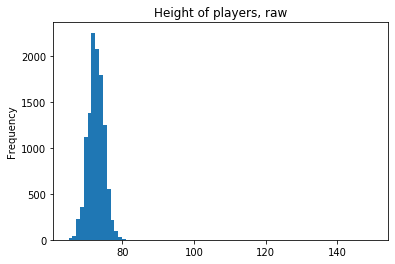

In [12]:
%matplotlib inline
col = 'height'
df[col].plot(kind='hist', bins=80,
             title="Height of players, raw")
df[col].describe()

In [13]:
mask = df[col] > 90
df[mask]

,amateurClubName,amateurLeague,birthDate,birthPlace,countryCode,csPlayerId,draftYear,draftedByTeamId,firstName,height,...,removedOutrightWhy,roundNumber,shootsCatches,supplementalDraft,teamPickHistory,triCode,weight,birth_city,birth_country,birth_state
4181,Timra,Sweden,1962-03-02,"Federtalve, Sweden",SWE,NaN,1980-01-01,15,Peter,150.0,...,NaN,9,R,N,WSH,WSH,150.0,Federtalve,Sweden,NaN
8919,Cherepovets Severstal,Russia,1981-06-23,"Ust-Kamenogorsk, Kazakhstan",KAZ,45565.0,1999-01-01,4,Konstantin,123.0,...,NaN,6,R,N,PHI,PHI,123.0,Ust-Kamenogorsk,Kazakhstan,NaN


In [14]:
df.loc[mask, col] = df[col].mean()
print("Erratic height values replaced with mean.")

Erratic height values replaced with mean.


count    11433.000000
mean        72.668272
std          2.085642
min         65.000000
25%         71.000000
50%         73.000000
75%         74.000000
max         81.000000
Name: height, dtype: float64

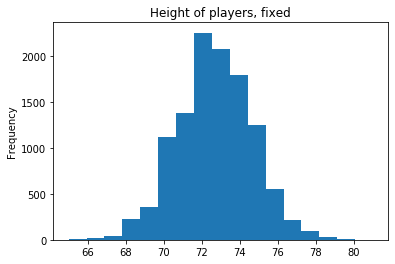

In [15]:
df[col].plot(kind='hist', bins=17,
             title="Height of players, fixed")
df[col].describe()

Height of players follows a normal (Gaussian) distribution, as expected.

### Fixing erratic `weight` values

count    11433.000000
mean       191.462258
std         16.237586
min         19.000000
25%        180.000000
50%        190.000000
75%        201.000000
max        265.000000
Name: weight, dtype: float64

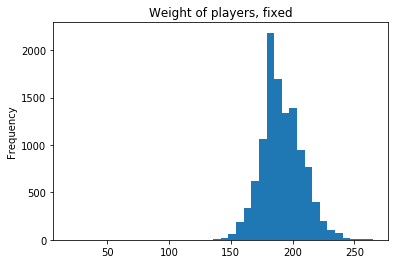

In [16]:
col = 'weight'
df[col].plot(kind='hist', bins=40,
             title="Weight of players, fixed")
df[col].describe()

In [17]:
mask = df[col] < 130
df[mask]

,amateurClubName,amateurLeague,birthDate,birthPlace,countryCode,csPlayerId,draftYear,draftedByTeamId,firstName,height,...,removedOutrightWhy,roundNumber,shootsCatches,supplementalDraft,teamPickHistory,triCode,weight,birth_city,birth_country,birth_state
8365,Notre Dame,NCAA,1978-06-14,"Shaker Heights, Oh Usa",USA,47155.0,1997-01-01,16,Benjamin,72.000000,...,NaN,5,L,N,CHI,CHI,19.0,Shaker Heights,USA,Oh
8496,NaN,Czech Republic,1974-02-22,"Benesov, Czech Republic",CZE,47965.0,1997-01-01,1,Jan,72.000000,...,NaN,9,L,N,NJD,NJD,100.0,Benesov,Czech Republic,NaN
8919,Cherepovets Severstal,Russia,1981-06-23,"Ust-Kamenogorsk, Kazakhstan",KAZ,45565.0,1999-01-01,4,Konstantin,72.679437,...,NaN,6,R,N,PHI,PHI,123.0,Ust-Kamenogorsk,Kazakhstan,NaN


In [18]:
df.loc[mask, col] = df[col].mean()
print("Erratic weight values replaced with mean.")

Erratic weight values replaced with mean.


count    11433.000000
mean       191.491331
std         16.121875
min        137.000000
25%        180.000000
50%        190.000000
75%        201.000000
max        265.000000
Name: weight, dtype: float64

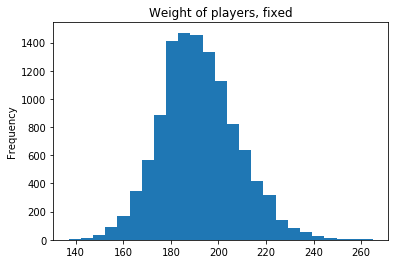

In [19]:
df[col].plot(kind='hist', bins=25,
             title="Weight of players, fixed")
df[col].describe()

Weight of players follows a normal (Gaussian) distribution, as expected.

### Remove redundant positions
All players capable of playing the center are assumed to be centers, LW/RW are assumed to be right wings, mixed D positions are assumed to be D.

In [20]:
col = 'position'
df[col].value_counts()

D        3758
C        2437
LW       1891
RW       1837
G        1142
F         357
C/LW       30
C/RW       17
LW/RW      13
LW/D        1
D/F         1
Name: position, dtype: int64

In [21]:
df[col] = df[col].str.replace("C/LW", "C")
df[col] = df[col].str.replace("C/RW", "C")
df[col] = df[col].str.replace("LW/RW", "RW")
df[col] = df[col].str.replace("LW/D", "D")
df[col] = df[col].str.replace("D/F", "D")
df[col] = df[col].str.replace("F", "C")
df[col].value_counts()

D     3760
C     2841
LW    1891
RW    1850
G     1142
Name: position, dtype: int64

## Produce new feature `first_round`
`1st_round`: boolean, whether the prospect was selected in the $1^{st}$ round
* one-hot encoding for $1^{st}$ round picks
* True if `round` == 1, False otherwise

In [24]:
df['first_round'] = df['roundNumber'] == 1
print("New column added!")

New column added!


## Filter and rename columns

In [28]:
cols = ['csPlayerId', 'playerName', 'countryCode', 
        'birthDate', 'birthPlace', 'birth_city', 
        'birth_state', 'birth_country',
        'amateurClubName', 'amateurLeague',
        'draftYear', 'draftedByTeamId', 
        'overallPickNumber', 'roundNumber', 'pickInRound',
        'height', 'weight', 'position', 'shootsCatches']
col_names = ['csPlayerId', 'name', 'nat', 
             'b_date', 'b_place', 'b_city', 
             'b_state', 'b_country',
             'ateam', 'league', 
             'year', 'dteam', 
             'overall', 'round', 'in_round', 
             'height', 'weight', 'pos', 'shoots']

df_filtered = df[cols].copy()
df_filtered.columns = col_names
print("DataFrame columns filtered and renamed.")

DataFrame columns filtered and renamed.


## Record results to a new .csv file

In [29]:
save_path = 'data/nhl_api/nhl_draft_all_precleaned.csv'
t = time()
df_filtered.to_csv(save_path, index=False)
elapsed = time() - t
print("DataFrame saved to file:\n", save_path,
      "\ntook {0:.2f} seconds".format(elapsed))

DataFrame saved to file:
 data/nhl_api/nhl_draft_all_precleaned.csv 
took 0.59 seconds
